Section 1.

This section gets data from the Twitter API and constructs a network based on mentions.

The first code snippet imports the libraries needed to construct the graph. Imports evolved from the C programming language in which used a concept similar to imports (include in C) to minimize the size of code. A simple program with all available python code might be in the terabytes range, whereas a program that uses only what is needed would be in the kilobytes/megabytes range.

In [1]:
import requests 
import json
import os
import pandas as pd
from math import ceil
import re
import time
from datetime import timedelta
import codecs
import networkx as nx

Section 2.

The next section contains functions that make interacting with the Twitter API easier.

Many endpoints in the Twitter API are more efficient if a set of accounts are grouped. This function takes the following arguments:
    group_size: the number of items in a group
    infile_path: path to Excel file with input accounts
    data_col: header of column with Twitter user names
And returns:
    a list of comma-delimited strings of group_size data_col 

In [2]:
def grouper(group_size,infile_path,data_col):

        '''
        Make a list of lists of csvs with length group_size

        group_size: batch size of groups
        infile_path: path to Excel file with input accounts
        users_col: header of column with Twitter user names
        '''
        # Declare file path and group size
        # See Twitter API docs for max group size related to your call
        df = pd.read_excel(infile_path)
        
        # get list of accounts from DataFrame
        # remove @ signs and spaces
        accounts = [re.sub('[@ ]', '', z) for z in df[data_col].to_list()]
        
        # Parse to list of groups
        num_groups = ceil(len(accounts)/group_size)
        groups = []
        for i in range(num_groups): groups.append(','.join(accounts[i*group_size:(i+1)*(group_size)]))
        return groups

*** Add your API token below
This function is used when making a request to the Twitter API. 

In [26]:
bearer_token = 'Add API token here'
def oauth(r):
    '''API Authorization Callback'''
    r.headers['Authorization'] = f'Bearer {bearer_token}'
    r.headers['User-Agent'] = 'v2UserTweetsPython'
    return r

Use the function below to get data from the Twitter API. If the API is rate limiting (returns status code 429), the program waits 

The values of the variables below can be found in the Twitter API docs.

    url: API endpoint
    params: API parameters for endpoint
    rate_limit: API rate limit numbe of minutes (to be nice and not make unecessary calls to the API)


In [7]:
def connect_to_endpoint(url, params, rate_limit):
        '''
        API Connector

        rate_limit: rate limit in minutes
        url: API endpoint
        params: Query Parameters
        begin_time: unix time of query start
        '''
        begin_time = time.time()
        # for calculating wait times
        rate_limit_window = timedelta(minutes=rate_limit)


        # url, auth=bearer_oauth, params=params
        response = requests.request('GET', url=url, auth=oauth, params=params)
        # handle rate limit
        if response.status_code == 429:
            sleepy_time = rate_limit_window - timedelta(seconds=ceil(time.time()-begin_time))
            time.sleep(sleepy_time.seconds+10)

            #try again
            begin_time = time.time()
            return connect_to_endpoint(params, begin_time)

        elif response.status_code != 200:
            raise Exception(f'Error: {response.status_code} {response.text}')
        return response.json()

Section 3.

This section gets a list of users from a file with the Twitter accounts of CEOs on Twitter, and makes variables for use with the functions in Section 2.

In [8]:
# number of accounts in each request
# see API docs for limits
group_size = 20

# location of excel file with user accounts
in_file = 'in/ceo_sample.xlsx'

# column header with user accounts in in_file
user_column = 'Twitter Account'

#Twitter v2 API endpoint 
api_endpoint = 'https://api.twitter.com/2/users/by'

# number of minutes in rate limit
rate_limit = 15

Section 4.

The code below gets the Twitter user IDs for the screen names in the file. First, groups 20 (group_size = 20 in this example) comma-delimited users are constructed using the grouper function. Second, a separate API call is made for each group. On the first loop, a new file is made (m = 'w'); on subsequent loops, data is appended to the file (m = 'a'). We need these IDs because the API endpoint that we need to use takes IDs, but not user names.

In [18]:
# use the grouping code in twitter_rest
groups = grouper(group_size,in_file,user_column)
out_file = 'in/user_ids.json'

for k,users in enumerate(groups):
    params = {}
    params['usernames'] = users
    params['user.fields'] = 'verified,id,public_metrics,username'
    resp = connect_to_endpoint(api_endpoint,params,rate_limit)

    #write response to file
    if k == 0:
        m = 'w'
    else:
        m = 'a'
    with open(out_file, m) as f:
        for r in resp['data']:
            f.write(json.dumps(r)+'\n')

The code below goes to the max depth allowed with free-tier Twitter API access for each of the account IDs that we downloaded in the previous code snippet. Our goal here is to construct a network of the CEOs via their direct connections, so we parse the reply to ids here.

In [19]:
url = 'https://api.twitter.com/2/users/{id}/tweets'

with open('in/user_ids.json') as f:
    out_data = []

    for k,j in enumerate(f):
        user = json.loads(j)
        api_endpoint = url.format(id=user['id'])
        params = {}
        params['expansions'] = 'in_reply_to_user_id'
        params['max_results'] = 100
        
        resp = connect_to_endpoint(api_endpoint, params, rate_limit)
        try:
            while 'next_token' in resp['meta']:
                params['pagination_token'] = resp['meta']['next_token']
                resp = connect_to_endpoint(api_endpoint, params, rate_limit)
                for k,z in enumerate(resp['data']):
                    if 'in_reply_to_user_id' in z:
                        uid = user['id']
                        reply_uid = z['in_reply_to_user_id']
                        tweet_id = z['id']
                        text = codecs.encode(re.sub('\n', ' ', z['text']), 'utf-8',errors='ignore')
                        out_data.append([str(uid),str(reply_uid)])
        except:
            # here if user deleted their account
            continue
        
with open('out/edge_list3200.txt', 'w') as f:
    f.write('uid\treply_uid\n')
    for i in out_data:
        f.write('\t'.join(i)+'\n',)

Make a graph with Networkx

Graph with 2395 nodes and 2453 edges


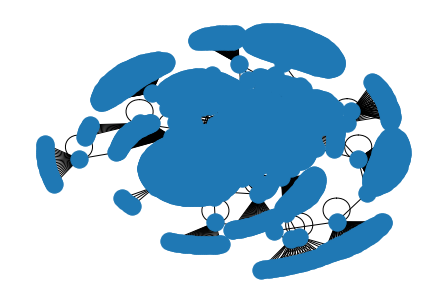

In [24]:
with open('out/edge_list3200.txt', 'rb') as f:
    # remove header
    next(f)

    # add source and target from edge list
    g = nx.read_edgelist(f, delimiter='\t')
print(g)
nx.draw(g, pos=nx.kamada_kawai_layout(g))